In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-image/Priv_personpart/Json_Annos/privpersonpart_train.json
/kaggle/input/human-image/Priv_personpart/Json_Annos/privpersonpart_val.json
/kaggle/input/human-image/Priv_personpart/tools/pascal2coco.py
/kaggle/input/human-image/Priv_personpart/Annotations/4d1618dc921e6016200c8f9217b57a826f313c7c.xml
/kaggle/input/human-image/Priv_personpart/Annotations/c0315fe969a687accd42c605dc7b834563612609.xml
/kaggle/input/human-image/Priv_personpart/Annotations/e613e38fe8dcd94136a75e2e269892a2db097afd.xml
/kaggle/input/human-image/Priv_personpart/Annotations/c8eb82bc487c05790160bba5c0abaf4a8beeda53.xml
/kaggle/input/human-image/Priv_personpart/Annotations/5d7ea1ad8c9c25327d5764a83d5e76d4ac71d2d6.xml
/kaggle/input/human-image/Priv_personpart/Annotations/843d8e1481f10257542d81b08c30e767b0d50b83.xml
/kaggle/input/human-image/Priv_personpart/Annotations/2298d55c12751e3921feddcb791bf495f9838aa0.xml
/kaggle/input/human-image/Priv_personpart/Annotations/b54228535cafb8796d39bf3adb835c4f1b

In [2]:
#from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [3]:
from fastai.data.all import *
from fastai.vision.all import *

In [4]:
data_directory = "/kaggle/input/densenet-wound/Wound_dataset"
human_directory = "/kaggle/input/human-image/Priv_personpart/Images"

In [6]:
import os
new_directory_path = '/kaggle/working/output/Class_1' #CLASS 2 NO_wound, CLASS 1 -- WOUND

# Check if the directory already exists
if not os.path.exists(new_directory_path):
    os.makedirs(new_directory_path)
    print("Directory  created.")
else:
    print("Directory already exists.")

Directory  created.


In [7]:
def count_images(source_folder):
    # Initialize a counter for the total number of images
    total_images = 0
    
    # Iterate through all files and subdirectories in the source folder
    for root, _, files in os.walk(source_folder):
        for file in files:
            # Check if the file is an image (you can extend this check for other formats)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Increment the total image count
                total_images += 1

    return total_images

In [8]:
import os
import shutil

def copy_images(source_folder, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Iterate through all files and subdirectories in the source folder
    for root, _, files in os.walk(source_folder):
        for file in files:
            # Check if the file is an image (you can extend this check for other formats)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Create the source file path
                source_file_path = os.path.join(root, file)
                # Create the destination file path
                destination_file_path = os.path.join(destination_folder, file)
                # Copy the file to the destination folder
                shutil.copy(source_file_path, destination_file_path)
                #print(f"Copied '{file}' to '{destination_folder}'")
    total_images = count_images(destination_folder)
    print(f"Total number of images: {total_images}")
    print("Done")

In [9]:
# Example usage:
#source_folder = '/path/to/source_folder'
destination_folder = '/kaggle/working/output/Class_1'
copy_images(data_directory, destination_folder)

Total number of images: 431
Done


In [10]:
# Example usage:
#source_folder = '/path/to/source_folder'
destination_folder = '/kaggle/working/output/Class_2'
copy_images(human_directory, destination_folder)

Total number of images: 14962
Done


In [11]:
!pip install split-folders

In [12]:
import splitfolders

In [14]:
import os
new_directory_path = '/kaggle/working/new_output'

# Check if the directory already exists
if not os.path.exists(new_directory_path):
    os.makedirs(new_directory_path)
    print("Directory  created.")
else:
    print("Directory already exists.")

Directory already exists.


In [15]:
splitfolders.ratio("/kaggle/working/output", output="/kaggle/working/new_output", seed=2023, ratio=(.8, 0.2,0.0))

Copying files: 15393 files [00:03, 4131.91 files/s]


In [16]:
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

#folder_path = '/kaggle/working/new_output'
#remove_folder_contents(folder_path)
#os.rmdir(folder_path)

In [17]:
def generate_data_paths(data_dir):

    path = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            path.append(fpath)
            labels.append(fold)

    return path, labels

path, labels = generate_data_paths("/kaggle/working/new_output/train")
path_test, labels_test = generate_data_paths("/kaggle/working/new_output/val")

In [18]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'path')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(path, labels)

df.head()

path  \
0  /kaggle/working/new_output/train/Class_2/ea60732786f308fca42ebad1d1593b36430d3f71.jpg   
1  /kaggle/working/new_output/train/Class_2/d8be130a835617d39281a565c6c88dca592bb7a5.jpg   
2  /kaggle/working/new_output/train/Class_2/f4b9b905c8ac16a9d59c3252ad555d77b8a89505.jpg   
3  /kaggle/working/new_output/train/Class_2/2b8d7f5d9a378466c648b1c59e310ef896d34d88.jpg   
4  /kaggle/working/new_output/train/Class_2/9d4a5ecd91a63f9095cfab395b2f9939d715944a.jpg   

    labels  
0  Class_2  
1  Class_2  
2  Class_2  
3  Class_2  
4  Class_2

In [19]:
def num_of_classes(df):
    print(f"The dataset has: ")
    print("="*50)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*50)
    print(f"\nThe dataset has {len(df['labels'].unique())} classes and {df.shape[0]} images.")

num_of_classes(df)

The dataset has: 

Class 'Class_2' has 11969 images
--------------------------------------------------
Class 'Class_1' has 344 images
--------------------------------------------------

The dataset has 2 classes and 12313 images.


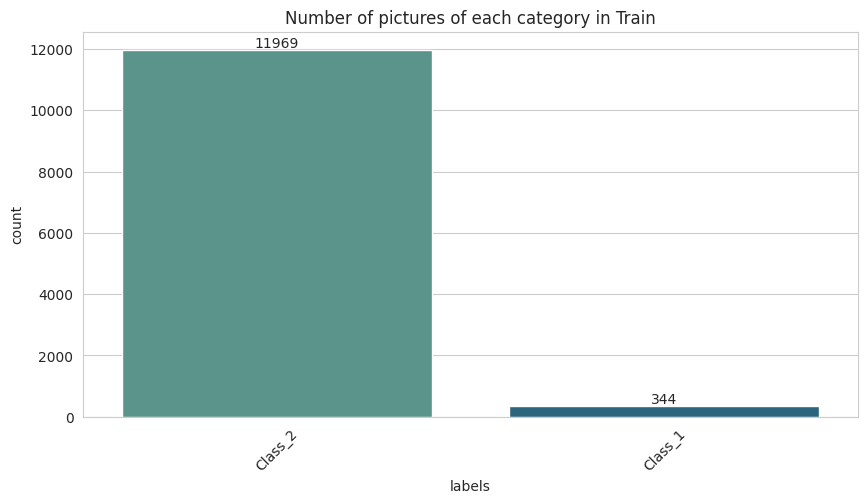

In [20]:
import seaborn as sns

sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(10,5))

ax = sns.countplot(x='labels',data=df, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of pictures of each category in Train')
plt.xticks(rotation=45)
plt.show()

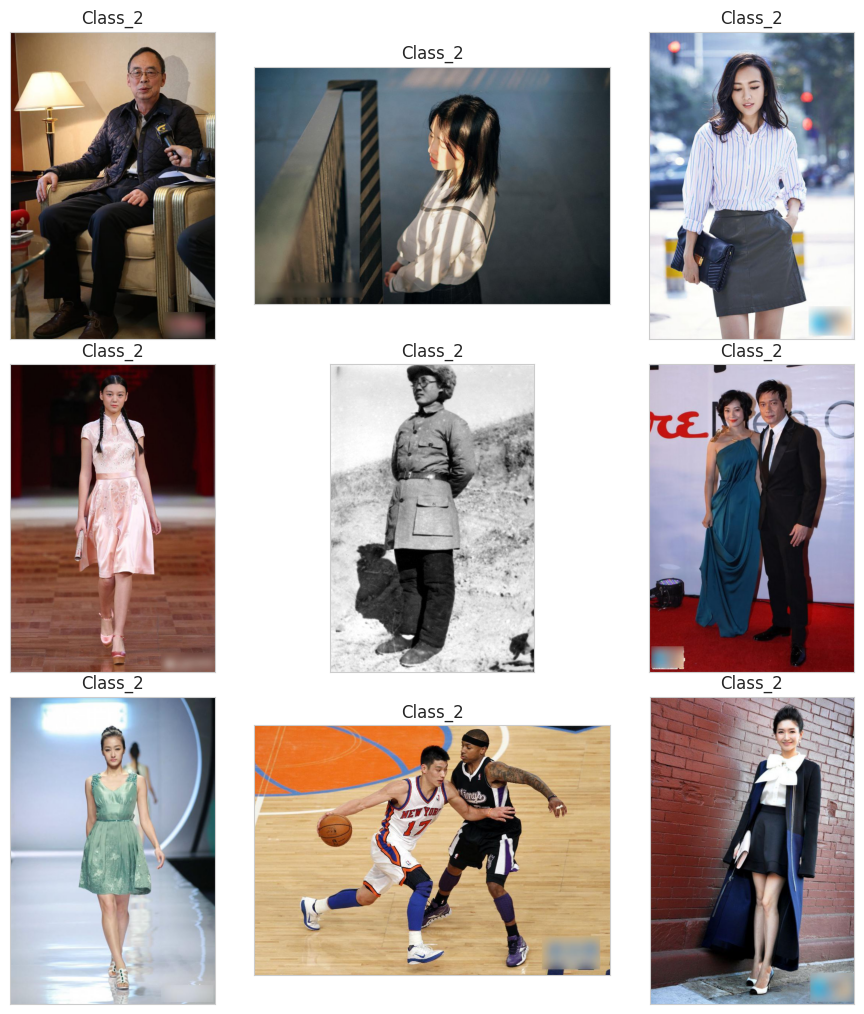

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    l=np.random.randint(0,len(labels))
    ax.imshow(plt.imread(df.path[l]))
    ax.set_title(df.labels[l], fontsize = 12)
plt.tight_layout(pad=0.2)
plt.show()

In [22]:
def label_funcs(fname):
    category = fname.parts[-2]  # Extract the category name from the path
    return category if category in labels else "unknown"

In [23]:
train_dir = "/kaggle/working/new_output/train"

In [24]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_funcs,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

dsets = dblock.datasets(train_dir)

In [25]:
dls = dblock.dataloaders(train_dir)

In [26]:
dblock=dblock.new(item_tfms=RandomResizedCrop(224,min_scale=0.5),batch_tfms=aug_transforms())
dls=dblock.dataloaders(train_dir)

In [29]:
learn = vision_learner(dls, vgg19_bn, metrics=[accuracy,error_rate])
learn.fine_tune(10)

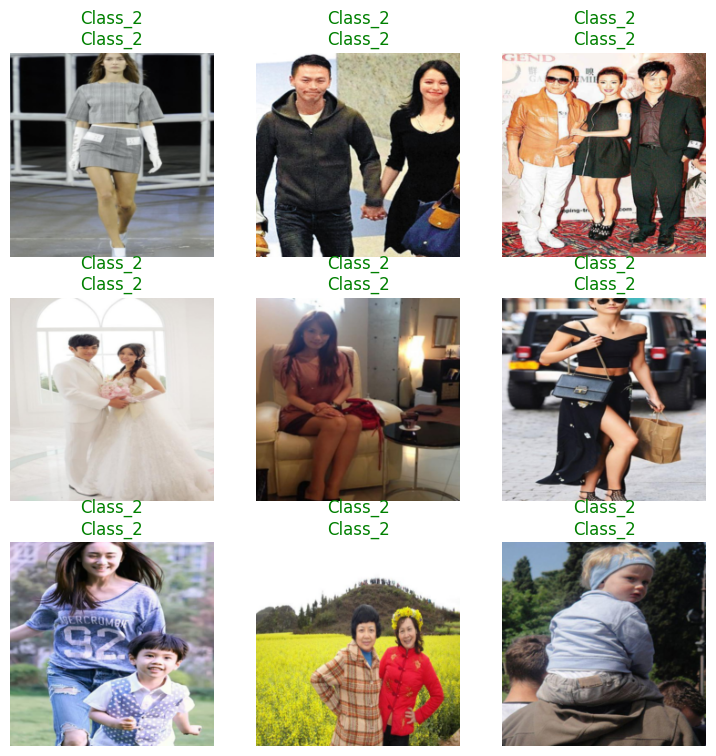

In [32]:
learn.show_results()

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

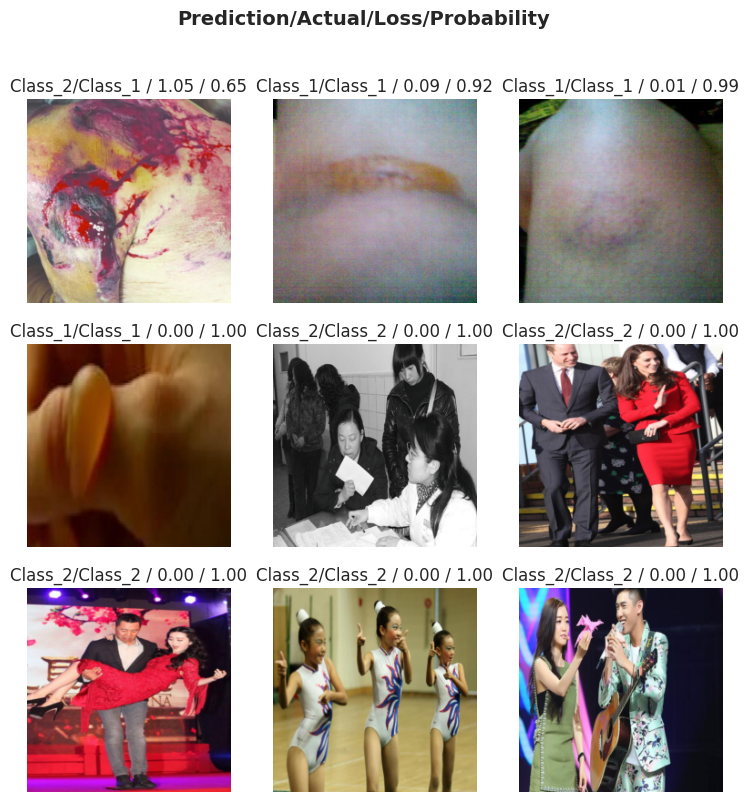

In [34]:
interp.plot_top_losses(9)

In [ ]:
preds, new_d, y_pred = learn.get_preds(dl=test_dl, with_decoded=True)

In [37]:
is_wound, _, confidence = learn.predict("/kaggle/input/densenet-wound/Wound_dataset/Class_1/abrasions (1).jpg")

In [39]:
confidence

tensor([1.0000e+00, 7.7119e-11])

In [35]:
learn.save('vggnet_humanmodel', with_opt=False)
learn.export('vggnet_humanmodel.pkl')

In [27]:
from torchvision import models

In [31]:
model_architectures = [resnet18, resnet34, resnet50, squeezenet1_0, squeezenet1_1, densenet121, densenet169, vgg16_bn, vgg19_bn]

In [32]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from fastai.vision.all import *

In [33]:
def iterate_over_architectures(data,labels_val,path_val, fine_tune_epochs=10):
    """
    Iterate over a list of model architectures, fine-tune each model on the given data, and return the results.

    Args:
    - data: Fastai DataLoaders object containing your dataset and dataloaders.
    - df_test: DataFrame containing test set information.
    - labels_val: Labels for the validation set.
    - fine_tune_epochs: The number of epochs to fine-tune each model.

    Returns:
    - A pandas DataFrame with model names, accuracy on the test set, accuracy on the validation set,
      F1 score on the test set, and F1 score on the validation set.
    - A pandas DataFrame storing all the predictions of each model in separate columns.
    """

    train_true = [1 if i == "no_wound" else 0 for i in df.labels]
    val_true = [1 if i == "no_wound" else 0 for i in labels_val]

    model_architectures = [resnet18, resnet34, resnet50, squeezenet1_0, squeezenet1_1, densenet121, densenet169, vgg16_bn, vgg19_bn]
    results = []
    
    val_predictions = pd.DataFrame()
    train_predictions = pd.DataFrame()

    for architecture in tqdm(model_architectures, desc="Model Progress"):
        # Create a learner for the specified architecture
        if 'resnet50' in str(architecture):
            learn = cnn_learner(data, architecture, pretrained=True, weights='IMAGENET1K_V2', metrics=accuracy)
        else:
            learn = cnn_learner(data, architecture, metrics=accuracy)

        # Fine-tune the model for the specified number of epochs
        learn.fine_tune(fine_tune_epochs)
        
        # Get predictions and calculate metrics for the test set
        train_dl = learn.dls.test_dl(df['path'])
        preds_train, _, train_pred = learn.get_preds(dl=train_dl, with_decoded=True)
        acc_train = accuracy_score(train_true, train_pred)
        f1_train = f1_score(train_true, train_pred, average="weighted")

        # Get predictions and calculate metrics for the validation set
        val_dl = learn.dls.test_dl(path_val)
        preds_val, _, val_pred = learn.get_preds(dl=val_dl, with_decoded=True)
        acc_val = accuracy_score(val_true, val_pred)
        f1_val = f1_score(val_true, val_pred, average="weighted")

        # Append results to the list
        results.append([architecture.__name__, acc_train, acc_val, f1_train, f1_val])

        # Store predictions in separate columns in all_predictions DataFrame
        val_predictions[f"{architecture.__name__}_Validation_Predictions"] = val_pred
        train_predictions[f"{architecture.__name__}_Train_Predictions"] = train_pred


    # Create a pandas DataFrame with the results
    result_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Validation Accuracy", "Train F1 Score","Validation F1 Score"])
    return result_df,val_predictions, train_predictions

In [34]:
path_test, labels_test

(['/kaggle/working/new_output/val/no_wound/fc7357d532a5775285bb7dec5ea8a9b070a39651.jpg',
  '/kaggle/working/new_output/val/no_wound/14b3311daff5362f622f5d61596e7ffa1f22f338.jpg',
  '/kaggle/working/new_output/val/no_wound/5693f0c989299b232b796d036f43df260765f41f.jpg',
  '/kaggle/working/new_output/val/no_wound/9418c2255352fbc9c09ba992a74462f77e19e76d.jpg',
  '/kaggle/working/new_output/val/no_wound/0884e07a2b7babfae6bc063a8eb182373fde1118.jpg',
  '/kaggle/working/new_output/val/no_wound/e025166ae7f7aa5795614e5a551fad799b2e5126.jpg',
  '/kaggle/working/new_output/val/no_wound/a9e3009b9954a0c95ccd2a5d66a7a45f2fbfbeb4.jpg',
  '/kaggle/working/new_output/val/no_wound/375aad36f2610872bbcc39a5618f7b63015c11c7.jpg',
  '/kaggle/working/new_output/val/no_wound/df048fd10d31a39bd97b9edacdaa86c6a5c5acf6.jpg',
  '/kaggle/working/new_output/val/no_wound/fb9b5537ac309e96a9caf00c9f7abfa81d721dec.jpg',
  '/kaggle/working/new_output/val/no_wound/0a3e0727e72cebd452b7d2eb61b4feb8f7cb8d37.jpg',
  '/kaggle

In [35]:
from scipy.stats import mode

In [36]:
number_epochs = 20

In [37]:
result = [1 if i == "no_wound" else 0 for i in labels_test]
pd.Series(result).value_counts()

1    2992
0      86
Name: count, dtype: int64

In [38]:
pd.Series(labels_test).value_counts()

no_wound    2992
wound         86
Name: count, dtype: int64

In [39]:
# Get the results for both test and validation sets
result_df,val_predictions, train_predictions = iterate_over_architectures(data = dls, labels_val = labels_test, path_val = path_test, fine_tune_epochs = number_epochs)

Model Progress:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

  0%|          | 0.00/44.7M [00:00<?, ?B/s]
 22%|██▏       | 10.0M/44.7M [00:00<00:00, 105MB/s]
 46%|████▌     | 20.5M/44.7M [00:00<00:00, 108MB/s]
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


Model Progress:  11%|█         | 1/9 [17:16<2:18:08, 1036.02s/it]/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth

  0%|          | 0.00/83.3M [00:00<?, ?B/s]
  8%|▊         | 6.49M/83.3M [00:00<00:01, 67.3MB/s]
 18%|█▊        | 15.0M/83.3M [00:00<00:00, 79.9MB/s]
 27%|██▋       | 22.6M/83.3M [00:00<00:00, 77.9MB/s]
 37%|███▋      | 30.4M/83.3M [00:00<00:00, 79.6MB/s]
 46%|████▌     | 38.0M/83.3M [00:00<00:00, 76.5MB/s]
 55%|█████▌    | 46.0M/83.3M [00:00<00:00, 78.9MB/s]
 65%|██████▍   | 53.9M/83.3M [00:00<00:00, 79.8MB/s]
 75%|███████▌  | 62.5M/83.3M [00:00<00:00, 82.6MB/s]
 86%|████████▌ | 71.2M/83.3M [00:00<00:00, 85.4MB/s]
100%|██████████| 83.3M/83.3M [0

Model Progress:  22%|██▏       | 2/9 [40:06<2:23:48, 1232.58s/it]/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth

  0%|          | 0.00/97.8M [00:00<?, ?B/s]
 10%|█         | 10.0M/97.8M [00:00<00:00, 105MB/s]
 27%|██▋       | 26.3M/97.8M [00:00<00:00, 143MB/s]
 43%|████▎     | 42.5M/97.8M [00:00<00:00, 156MB/s]
 59%|█████▉    | 57.9M/97.8M [00:00<00:00, 158MB/s]
 75%|███████▍  | 73.2M/97.8M [00:00<00:00, 159MB/s]
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


Model Progress:  33%|███▎      | 3/9 [1:20:00<2:56:18, 1763.15s/it]/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth

  0%|          | 0.00/4.78M [00:00<?, ?B/s]
100%|██████████| 4.78M/4.78M [00:00<00:00, 25.5MB/s]


Model Progress:  44%|████▍     | 4/9 [1:37:06<2:02:40, 1472.14s/it]/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth

100%|██████████| 4.73M/4.73M [00:00<00:00, 63.0MB/s]


Model Progress:  56%|█████▌    | 5/9 [1:53:12<1:25:58, 1289.56s/it]/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth

  0%|          | 0.00/30.8M [00:00<?, ?B/s]
 19%|█▉        | 5.99M/30.8M [00:00<00:00, 62.7MB/s]
 41%|████      | 12.7M/30.8M [00:00<00:00, 67.1MB/s]
 63%|██████▎   | 19.5M/30.8M [00:00<00:00, 68.6MB/s]
100%|██████████| 30.8M/30.8M [00:00<00:00, 71.8MB/s]


Model Progress:  67%|██████▋   | 6/9 [2:35:28<1:25:39, 1713.26s/it]/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth

  0%|          | 0.00/54.7M [00:00<?, ?B/s]
  2%|▏         | 1.30M/54.7M [00:00<00:04, 13.5MB/s]
 16%|█▌        | 8.54M/54.7M [00:00<00:00, 50.1MB/s]
 44%|████▍     | 24.0M/54.7M [00:00<00:00, 101MB/s] 
100%|██████████| 54.7M/54.7M [00:00<00:00, 119MB/s]


Model Progress:  78%|███████▊  | 7/9 [3:26:13<1:11:37, 2148.74s/it]/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth

  0%|          | 0.00/528M [00:00<?, ?B/s]
  1%|          | 6.03M/528M [00:00<00:08, 62.9MB/s]
  2%|▏         | 13.1M/528M [00:00<00:07, 69.6MB/s]
  4%|▍         | 20.1M/528M [00:00<00:07, 69.8MB/s]
  5%|▌         | 27.5M/528M [00:00<00:07, 72.7MB/s]
  7%|▋         | 35.2M/528M [00:00<00:06, 75.7MB/s]
  8%|▊         | 42.5M/528M [00:00<00:06, 74.8MB/s]
  9%|▉         | 49.8M/528M [00:00<00:06, 75.4MB/s]
 11%|█         | 57.5M/528M [00:00<00:06, 77.3MB/s]
 12%|█▏        | 64.9M/528M [00:00<00:06, 75.5MB/s]
 14%|█▎        | 72.2M/528M [00:01<00:0

Model Progress:  89%|████████▉ | 8/9 [4:27:51<44:01, 2641.89s/it]  /opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth

  0%|          | 0.00/548M [00:00<?, ?B/s]
  1%|          | 6.25M/548M [00:00<00:08, 65.4MB/s]
  2%|▏         | 13.6M/548M [00:00<00:07, 72.5MB/s]
  4%|▍         | 21.1M/548M [00:00<00:07, 75.3MB/s]
  5%|▌         | 29.0M/548M [00:00<00:06, 78.2MB/s]
  7%|▋         | 36.6M/548M [00:00<00:06, 78.6MB/s]
  8%|▊         | 44.1M/548M [00:00<00:06, 78.7MB/s]
  9%|▉         | 51.7M/548M [00:00<00:06, 74.4MB/s]
 11%|█         | 58.8M/548M [00:00<00:07, 71.3MB/s]
 12%|█▏        | 66.7M/548M [00:00<00:06, 74.7MB/s]
 14%|█▎        | 74.4M/548M [00:01<00:0

Model Progress: 100%|██████████| 9/9 [5:39:05<00:00, 2260.65s/it]


In [40]:
result_df

Model  Train Accuracy  Validation Accuracy  Train F1 Score  \
0       resnet18        0.000162             0.000975        0.000316   
1       resnet34        0.000244             0.000650        0.000320   
2       resnet50        0.000081             0.000325        0.000158   
3  squeezenet1_0        0.000162             0.001624        0.000316   
4  squeezenet1_1        0.000325             0.001949        0.000325   
5    densenet121        0.000000             0.000650        0.000000   
6    densenet169        0.000081             0.000975        0.000158   
7       vgg16_bn        0.000162             0.000975        0.000316   
8       vgg19_bn        0.000162             0.001300        0.000316   

   Validation F1 Score  
0             0.000054  
1             0.000036  
2             0.000018  
3             0.000091  
4             0.000109  
5             0.000036  
6             0.000054  
7             0.000054  
8             0.000073